In [58]:
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image

from dataLoader import OrganoidDataset
from conv_model import SimpleConvNet
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

In [3]:
use_cuda

True

In [4]:
figure_path = '../milestoneReport/figures/'
path = '../data/CS231n_Tim_Shan_example_data/'

# load data

In [79]:

import pandas 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
  'shuffle': True, 'num_workers' : 4}

max_epochs = 100

path = '../data/CS231n_Tim_Shan_example_data/'
well_descriptions = pandas.read_csv('filtered_well_descriptions.txt', header=0)
day1wells = well_descriptions['well_id']
day1wells = day1wells[well_descriptions['day'] == 1]
day1wells.shape
day13wells = well_descriptions['well_id']
day13wells = day13wells[well_descriptions['day'] == 13]
day13wells.shape
daysLabel = pandas.Series(list(set(day13wells) & set(day1wells)))


well_labels = []
for i in range(daysLabel.shape[0]):
  i2str = str(daysLabel[i])
  if len(i2str) == 1:
    i2str = '000' + i2str
  if len(i2str) == 2:
    i2str = '00' + i2str
  if len(i2str) == 3:
    i2str = '0' + i2str
  well_labels.append(i2str)

day_label_X = ['01']*len(well_labels)
n = len(well_labels)

finalSizes = well_descriptions['hyst2_area']
finalSizes = finalSizes[np.logical_and(well_descriptions['day'] == 13, np.isin(well_descriptions['well_id'], daysLabel))].values

day1_mean_and_var = pandas.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels[:100], day_label_X = day_label_X[:100], Y = finalSizes[:100], intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
training_generator = data.DataLoader(initial_train_set, **params)


In [18]:
NUM_TRAIN = 100
NUM_VAL = 100


In [6]:
finalSizes.shape

(4642,)

In [131]:
well_descriptions['hyst2_area'].shape

(64775,)

In [133]:
len(well_labels)

4642

In [136]:
well_descriptions

(64775, 9)

In [7]:
TOTAL = 100

In [8]:
len(day1wells)

4721

In [9]:
initial_val_set = OrganoidDataset(path2files = path, well_labels = well_labels[100:200], day_label_X = day_label_X[100:200], Y = finalSizes[100:200], intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
validation_generator = data.DataLoader(initial_val_set, **params)


# preprocess data 
(ignore this part)

In [5]:
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

In [6]:
label = pd.read_csv(label_path)

In [7]:
new_columns = ['well_id','day','median_pixel_intensity','mw_area_shape','original_hyst1_area','original_hyst2_area']
label.columns = new_columns

In [8]:
def get_image_name(well_id,day_id):
    image_name = 'well'+str(well_id).zfill(4)+'_day'+str(day_id).zfill(2)+'_well.png'
    return image_name
def get_well_label(well_id):
    return str(well_id).zfill(4)

In [9]:
label['image_name'] = label[['well_id','day']].apply(lambda x: get_image_name(*x),axis=1)
label['well_label'] = label['well_id'].apply(lambda x: get_well_label(x))

In [10]:
label.head(2)

,well_id,day,median_pixel_intensity,mw_area_shape,original_hyst1_area,original_hyst2_area,image_name,well_label
0,0,0,125.0,7830,512,418,well0000_day00_well.png,0000
1,1,0,125.0,8265,3044,3008,well0001_day00_well.png,0001


In [11]:
label.query("mw_area_shape > 32000").sort_values(by=['well_id','day'])

,well_id,day,median_pixel_intensity,mw_area_shape,original_hyst1_area,original_hyst2_area,image_name,well_label
43203,3,9,133.0,33124,14317,13965,well0003_day09_well.png,0003
33605,5,7,144.0,33124,14895,14654,well0005_day07_well.png,0005
48005,5,10,132.0,33124,12929,12666,well0005_day10_well.png,0005
57605,5,12,135.0,33124,13279,12997,well0005_day12_well.png,0005
19207,7,4,132.0,33124,14855,14586,well0007_day04_well.png,0007
43223,23,9,133.0,33124,17816,17288,well0023_day09_well.png,0023
33625,25,7,144.0,33124,20824,19976,well0025_day07_well.png,0025
43225,25,9,127.0,33124,23727,23129,well0025_day09_well.png,0025
52825,25,11,128.0,33124,29729,29134,well0025_day11_well.png,0025
14430,30,3,143.0,33124,13660,13486,well0030_day03_well.png,0030


In [12]:
excluded_well_id = set(label.query("mw_area_shape >= 32000")['well_id'].tolist())

In [13]:
len(excluded_well_id)

1510

In [14]:
label.isin(excluded_well_id).shape

(67200, 8)

In [15]:
corrected_labels = label.query("mw_area_shape < 32000")

In [16]:
# def normalize_label()

In [17]:
# corrected_labels['hyst1_area'] = corrected_labels['original_hyst1_area']/(corrected_labels['original_hyst1_area'].std())
# corrected_labels['hyst2_area'] = corrected_labels['original_hyst2_area']/(corrected_labels['original_hyst2_area'].std())

In [18]:
# corrected_labels.to_csv('filtered_well_descriptions.txt')

In [19]:
day1wells = corrected_labels.query("day == 1")
day13wells = corrected_labels.query("day == 13")

In [20]:
day1wells.shape, day13wells.shape

((4721, 8), (4712, 8))

In [21]:
merged_days = day1wells.merge(day13wells, on=['well_label'],suffixes=['_1','_13'])

In [22]:
merged_days.shape

(4642, 15)

In [23]:
merged_days

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,well_id_13,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13
0,0,1,141.0,7990,434,234,well0000_day01_well.png,0000,0,13,141.0,7216,1317,1095,well0000_day13_well.png
1,1,1,142.0,7482,39,0,well0001_day01_well.png,0001,1,13,140.0,7482,2125,1995,well0001_day13_well.png
2,2,1,143.0,7395,26,0,well0002_day01_well.png,0002,2,13,140.0,7568,849,667,well0002_day13_well.png
3,3,1,146.0,7396,392,315,well0003_day01_well.png,0003,3,13,142.0,7568,648,353,well0003_day13_well.png
4,4,1,147.0,7830,85,0,well0004_day01_well.png,0004,4,13,141.0,7654,179,0,well0004_day13_well.png
5,5,1,147.0,9167,493,375,well0005_day01_well.png,0005,5,13,141.0,7310,1387,1282,well0005_day13_well.png
6,6,1,145.0,7744,46,0,well0006_day01_well.png,0006,6,13,140.0,7396,602,496,well0006_day13_well.png
7,7,1,145.0,7568,106,0,well0007_day01_well.png,0007,7,13,140.0,7224,1197,1025,well0007_day13_well.png
8,8,1,146.0,7568,25,0,well0008_day01_well.png,0008,8,13,137.0,7308,863,763,well0008_day13_well.png
9,9,1,147.0,7656,22,0,well0009_day01_well.png,0009,9,13,135.0,7224,273,148,well0009_day13_well.png


In [24]:
merged_days = merged_days.sample(frac=1).reset_index(drop=True)

In [25]:
size_std = merged_days['original_hyst2_area_13'].std()

In [26]:
merged_days['hyst2_area_13'] = merged_days['original_hyst2_area_13']/size_std 

In [27]:
merged_days

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,well_id_13,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst2_area_13
0,2373,1,116.0,8099,8,0,well2373_day01_well.png,2373,2373,13,128.0,9025,142,0,well2373_day13_well.png,0.000000
1,3118,1,117.0,8099,29,0,well3118_day01_well.png,3118,3118,13,127.0,9660,25,0,well3118_day13_well.png,0.000000
2,490,1,140.0,11128,1286,942,well0490_day01_well.png,0490,490,13,146.0,7740,640,408,well0490_day13_well.png,0.320830
3,3986,1,118.0,9765,720,365,well3986_day01_well.png,3986,3986,13,128.0,9504,1015,703,well3986_day13_well.png,0.552803
4,2475,1,120.0,7654,100,0,well2475_day01_well.png,2475,2475,13,131.0,9476,1091,788,well2475_day13_well.png,0.619643
5,3001,1,116.0,7650,536,220,well3001_day01_well.png,3001,3001,13,132.0,6478,64,0,well3001_day13_well.png,0.000000
6,1236,1,118.0,14300,2857,2329,well1236_day01_well.png,1236,1236,13,132.0,6396,198,78,well1236_day13_well.png,0.061335
7,3635,1,115.0,8742,19,0,well3635_day01_well.png,3635,3635,13,126.0,8554,1275,880,well3635_day13_well.png,0.691987
8,4598,1,117.0,8184,7,0,well4598_day01_well.png,4598,4598,13,128.0,8556,268,0,well4598_day13_well.png,0.000000
9,72,1,146.0,7832,20,0,well0072_day01_well.png,0072,72,13,133.0,7138,363,233,well0072_day13_well.png,0.183219


In [28]:
#merged_days.to_csv("filtered_merged_well_description.csv")

In [29]:
well_labels = merged_days['well_label']
finalSizes = merged_days['hyst2_area_13']
day_label_X = ['01']*len(well_labels)

In [30]:
merged_days[100:200]

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,well_id_13,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst2_area_13
100,2183,1,127.0,8188,11,0,well2183_day01_well.png,2183,2183,13,126.0,8736,5,0,well2183_day13_well.png,0.000000
101,1871,1,127.0,8460,13,0,well1871_day01_well.png,1871,1871,13,135.0,6800,376,191,well1871_day13_well.png,0.150193
102,381,1,144.0,7476,276,248,well0381_day01_well.png,0381,381,13,155.0,10201,395,308,well0381_day13_well.png,0.242195
103,771,1,139.0,7482,378,346,well0771_day01_well.png,0771,771,13,142.0,8910,1029,903,well0771_day13_well.png,0.710073
104,115,1,145.0,7743,17,0,well0115_day01_well.png,0115,115,13,136.0,8051,278,0,well0115_day13_well.png,0.000000
105,688,1,142.0,9200,364,0,well0688_day01_well.png,0688,688,13,149.0,8008,748,60,well0688_day13_well.png,0.047181
106,4688,1,118.0,8184,5,0,well4688_day01_well.png,4688,4688,13,126.0,8640,22,0,well4688_day13_well.png,0.000000
107,4731,1,117.0,8190,937,615,well4731_day01_well.png,4731,4731,13,126.0,8455,1266,1221,well4731_day13_well.png,0.960132
108,3868,1,119.0,8010,61,0,well3868_day01_well.png,3868,3868,13,129.0,8370,235,122,well3868_day13_well.png,0.095935
109,2658,1,121.0,8188,1,0,well2658_day01_well.png,2658,2658,13,131.0,8464,189,0,well2658_day13_well.png,0.000000


In [31]:
# for i in range(4800):
#     well_labels.append(str(i).zfill(4))

In [32]:
NUM_TRAIN = 100
#TOTAL = merged_days.shape[0]
#NUM_VAL = TOTAL-NUM_TRAIN
NUM_VAL = 100

In [33]:
training_set = merged_days[:NUM_TRAIN]
val_set = merged_days[100:200]

In [34]:
train_well_labels = training_set['well_label']
train_size = training_set['hyst2_area_13'].values.reshape(100,1)

val_well_labels = val_set['well_label']
val_size =val_set['hyst2_area_13'].values.reshape(100,1)

In [35]:
merged_days.shape

(4642, 16)

In [36]:
val_set.shape

(100, 16)

In [37]:
training_set.shape

(100, 16)

In [38]:
val_size.shape, train_size.shape

((100, 1), (100, 1))

In [39]:
well_labels[-100:].shape

(100,)

In [40]:
day1_mean_and_var = pd.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels[:100], day_label_X = day_label_X[:100], Y = finalSizes[:100]
                                    , intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
# training_generator = data.DataLoader(initial_train_set, **params)

In [41]:
path = '../data/CS231n_Tim_Shan_example_data/'
train_set = OrganoidDataset(path2files = path, well_labels = train_well_labels, day_label_X = ['01']*NUM_TRAIN, Y = train_size
                                   , intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
# training_generator = data.DataLoader(initial_train_set,  batch_size=64, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [42]:

training_generator = data.DataLoader(train_set, **params)

In [43]:
NUM_TRAIN, NUM_VAL

(100, 100)

In [44]:
initial_val_set = OrganoidDataset(path2files = path, well_labels = well_labels[:100], day_label_X = day_label_X[100:200], Y = finalSizes[100:200], intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
validation_generator = data.DataLoader(initial_val_set, **params)

In [45]:
# validation_set =  OrganoidDataset(path2files = path, well_labels = well_labels[200:300], day_label_X = day_label_X[200:300], Y = finalSizes[200:300]
#                                      , intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])


In [46]:
validation_generator = data.DataLoader(initial_train_set, **params)

In [47]:
finalSizes[:100]

0     0.000000
1     0.000000
2     0.320830
3     0.552803
4     0.619643
5     0.000000
6     0.061335
7     0.691987
8     0.000000
9     0.183219
10    0.500118
11    2.381064
12    2.874105
13    0.000000
14    0.666824
15    0.000000
16    0.287017
17    0.142329
18    0.000000
19    0.000000
20    0.393961
21    0.000000
22    0.714791
23    1.085948
24    0.000000
25    0.121098
26    0.000000
27    0.067626
28    0.000000
29    0.000000
        ...   
70    0.000000
71    0.666037
72    0.274436
73    0.137611
74    0.000000
75    5.773373
76    0.725800
77    0.326335
78    0.000000
79    0.000000
80    0.000000
81    1.193678
82    0.581112
83    0.000000
84    0.491468
85    0.000000
86    0.241409
87    0.057403
88    0.000000
89    0.800503
90    0.000000
91    0.419124
92    0.055831
93    0.000000
94    0.182433
95    0.158842
96    0.077062
97    0.091216
98    0.222537
99    7.743963
Name: hyst2_area_13, Length: 100, dtype: float64

In [48]:
finalSizes.mean()

0.3984942233057524

# MODEL

In [49]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [50]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [51]:

def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    all_accuracy=[]
    error = 0
    num_samples = 0
    losses=[]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        totalbatchMSE = 0.0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            preds = model(x)
            #_, preds = scores.max(1)
            #num_correct += (preds == y).sum()
            #num_samples += preds.size(0)
            #print("pred ",preds.size(0))
            #print("y size",y.size(0))
            #error += (((y-preds)**2).sum())/num_samples
            val_loss = F.mse_loss(preds, y)
            val_error = val_loss.item()
            losses.append(val_error)
            totalbatchMSE = totalbatchMSE + params['batch_size']*val_error/NUM_VAL
        #error = float(error)
        #print('num samles',num_samples)
        
        print('val error:',val_error)
        #acc = error / num_samples
        all_accuracy.append(val_error)
        print('Got accuracy (%.2f)' % (100 * val_error))
    return totalbatchMSE,preds

In [52]:
def train_part34(model, optimizer, epochs=1):
    train_errors = []
    losses = {}
    epoch_error ={}
    all_accuracy =[]
    for e in range(epochs):
        print(e)
        totalbatchMSE = 0.0
        for t, (x, y) in enumerate(training_generator):
            #print('epoch: ',e)
            model.train() 
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            
            Y_hat = model(x)
            #loss = nn.MSELoss(Y_hat,y)
            loss = F.mse_loss(Y_hat, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            train_error = loss.item()
            
            totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/NUM_TRAIN
            
            #losses.append(train_error)
            losses[e] =train_error
            epoch_error[e] = totalbatchMSE
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, train_error))
                print("total_batch_mse",totalbatchMSE)
                train_errors.append(totalbatchMSE)
                val_accuracy,preds = check_accuracy_part34(validation_generator, model)
                all_accuracy.append(val_accuracy)
    return train_errors,all_accuracy,preds
    

In [53]:

# out_size = 1
# in_channels = 1 
# channel_1 = 32
# channel_2 = 16
# channel_3 = 8
# out_size = 1
# image_size = 193
# model = nn.Sequential(
#     nn.Conv2d(in_channels=in_channels,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),   
#     Flatten(),
#     nn.Linear(channel_2*image_size*image_size, 1,bias=True),
# )

In [54]:

out_size = 1
in_channels = 1 
channel_1 = 32
channel_2 = 16
channel_3 = 8
out_size = 1
image_size = 193
model = nn.Sequential(
    nn.Conv2d(in_channels=in_channels,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(), 
    nn.Conv2d(in_channels=channel_2,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    Flatten(),
    nn.Linear(channel_2*image_size*image_size, 1,bias=True),
)

In [55]:
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=595984, out_features=1, bias=True)
)

In [56]:
print_every = 100
epoches = 50
learning_rate = 1e-4

optimizer =optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=1.0, nesterov=True)

train_errors,val_accuracy,prediction = train_part34(model, optimizer,epochs=epoches)


0
Iteration 0, loss = 1.9638
total_batch_mse 1.9638473987579346
val error: 4.846631050109863
Got accuracy (484.66)
1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration 0, loss = 4.7232
total_batch_mse 4.723165512084961
val error: 2.0642666816711426
Got accuracy (206.43)
2
Iteration 0, loss = 1.9632
total_batch_mse 1.9632258415222168
val error: 2.1803603172302246
Got accuracy (218.04)
3
Iteration 0, loss = 2.0991
total_batch_mse 2.099059820175171
val error: 3.1213648319244385
Got accuracy (312.14)
4
Iteration 0, loss = 3.0152
total_batch_mse 3.015228271484375
val error: 2.7509703636169434
Got accuracy (275.10)
5
Iteration 0, loss = 2.5900
total_batch_mse 2.5900018215179443
val error: 1.9997191429138184
Got accuracy (199.97)
6
Iteration 0, loss = 1.7721
total_batch_mse 1.772118330001831
val error: 1.824786901473999
Got accuracy (182.48)
7
Iteration 0, loss = 1.5281
total_batch_mse 1.5281052589416504
val error: 2.2121851444244385
Got accuracy (221.22)
8
Iteration 0, loss = 1.8528
total_batch_mse 1.852773904800415
val error: 2.530888319015503
Got accuracy (253.09)
9
Iteration 0, loss = 2.1239
total_batch_mse 2.123884677886963
val error: 2.42681

In [127]:
torch.save(model.state_dict(),'initial_cnn_model_for_milestone')

# lr 1e-4

### with 100 image 

### different input

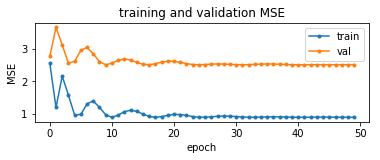

In [20]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.title("training and validation MSE")
#plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
#fig.savefig(figure_path+'train_val_MSE.pdf')

### adam 1e-4 with changing std

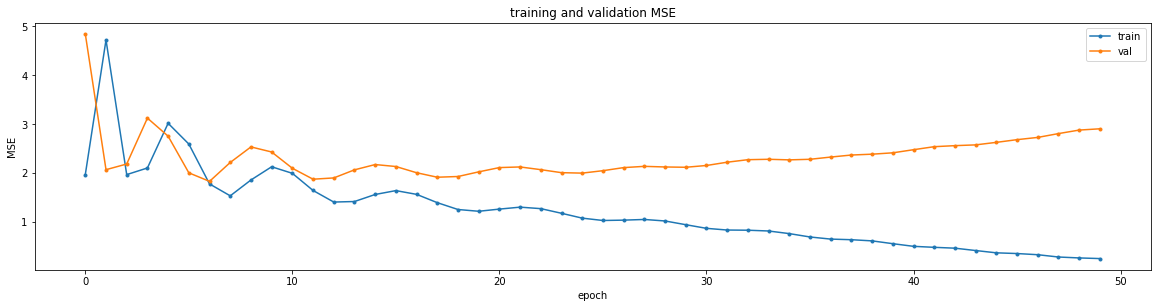

In [60]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.title("training and validation MSE")
#plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
fig.savefig(figure_path+'train_val_MSE.pdf')

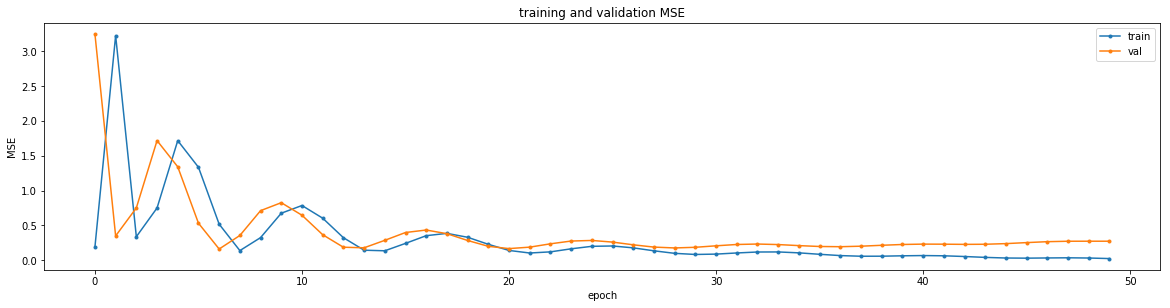

In [101]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.title("training and validation MSE")
#plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
#fig.savefig(figure_path+'train_val_MSE.pdf')

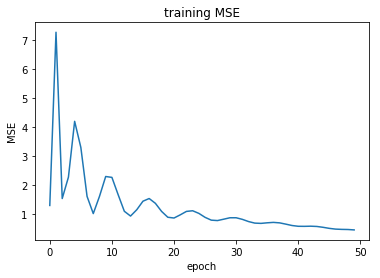

In [63]:
fig = plt.figure()
plt.plot(train_errors)
plt.title("training MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
fig.savefig(figure_path+'train_MSE.pdf')

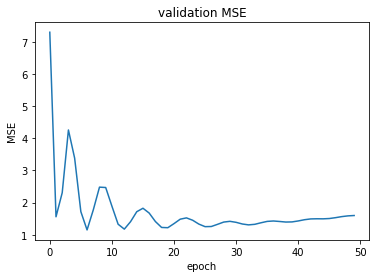

In [64]:
fig = plt.figure()
plt.plot(val_accuracy)
plt.title("validation MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
fig.savefig(figure_path+'val_MSE.pdf')

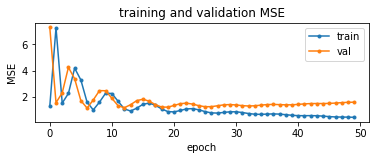

In [65]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.title("training and validation MSE")
#plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
fig.savefig(figure_path+'train_val_MSE.pdf')

### Adam 5e-6 

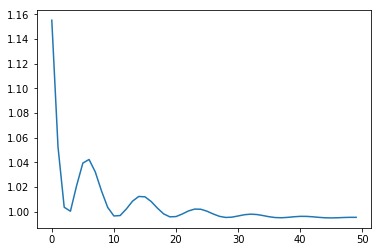

In [131]:
plt.plot(train_errors)

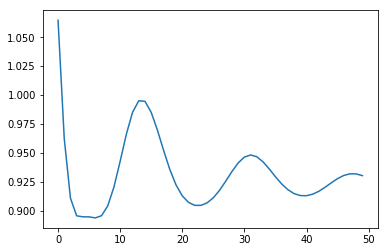

In [132]:
plt.plot(val_accuracy)

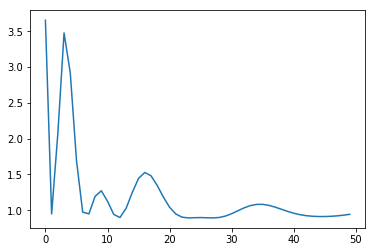

In [161]:
plt.plot(val_accuracy)

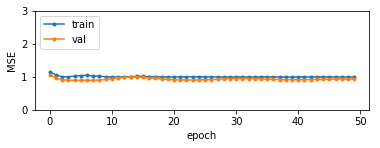

In [133]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### Shuffle data

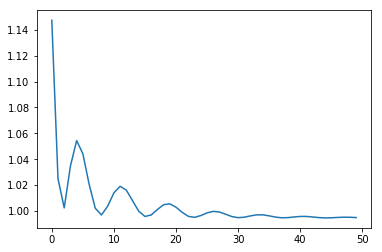

In [120]:
plt.plot(train_errors)

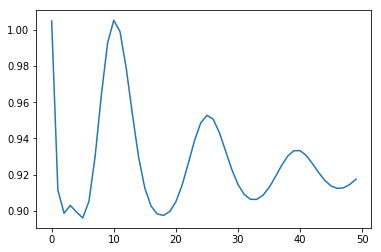

In [121]:
plt.plot(val_accuracy)

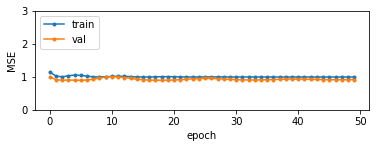

In [122]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### ADAM 1e-4

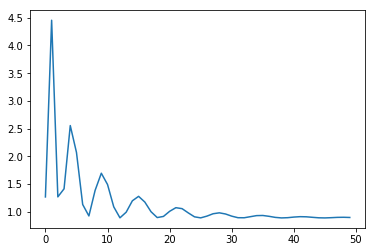

In [92]:
plt.plot(train_errors)

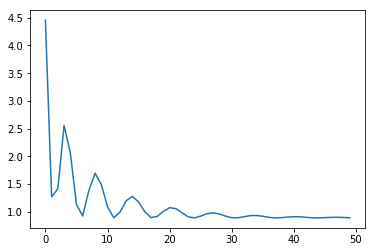

In [93]:
plt.plot(val_accuracy)

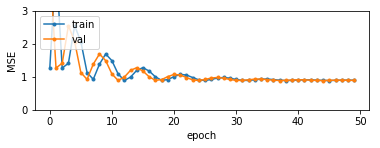

In [95]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### ADAM 1e-5

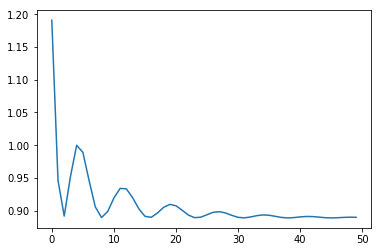

In [80]:
plt.plot(train_errors)

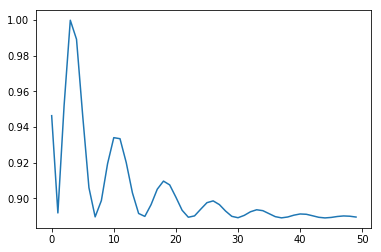

In [81]:
plt.plot(val_accuracy)

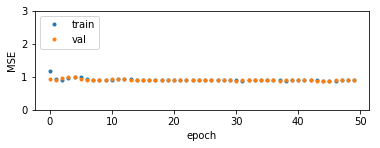

In [84]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.')
plt.plot(val_accuracy, '.')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### SGD

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


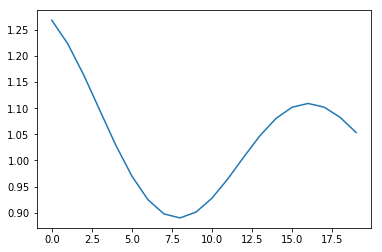

In [69]:
plt.plot(train_errors)

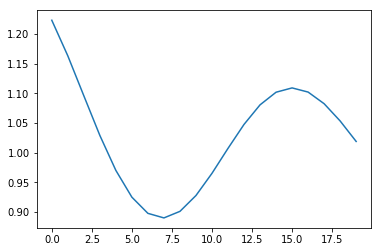

In [70]:
plt.plot(val_accuracy)

### OLD data set

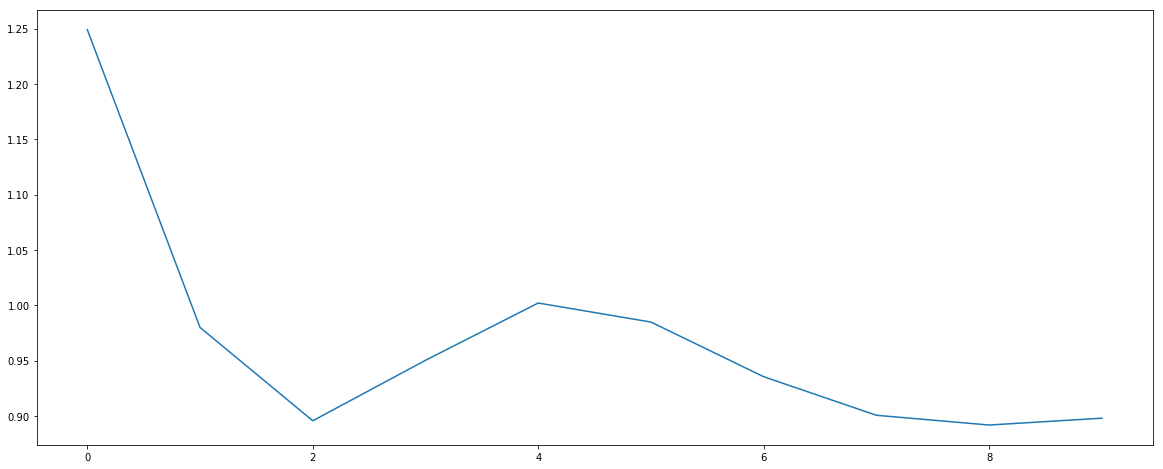

In [166]:
plt.plot(train_errors)

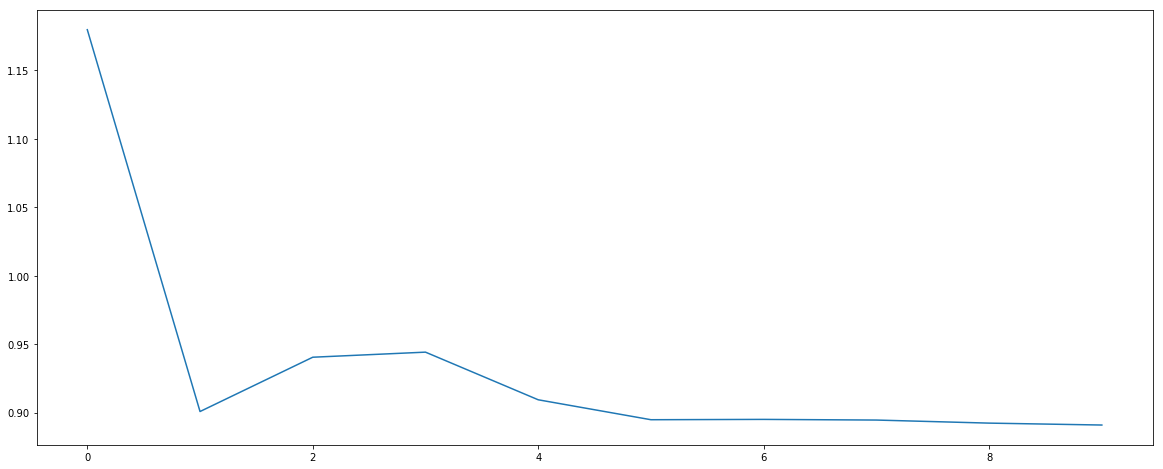

In [107]:
plt.plot(train_errors)

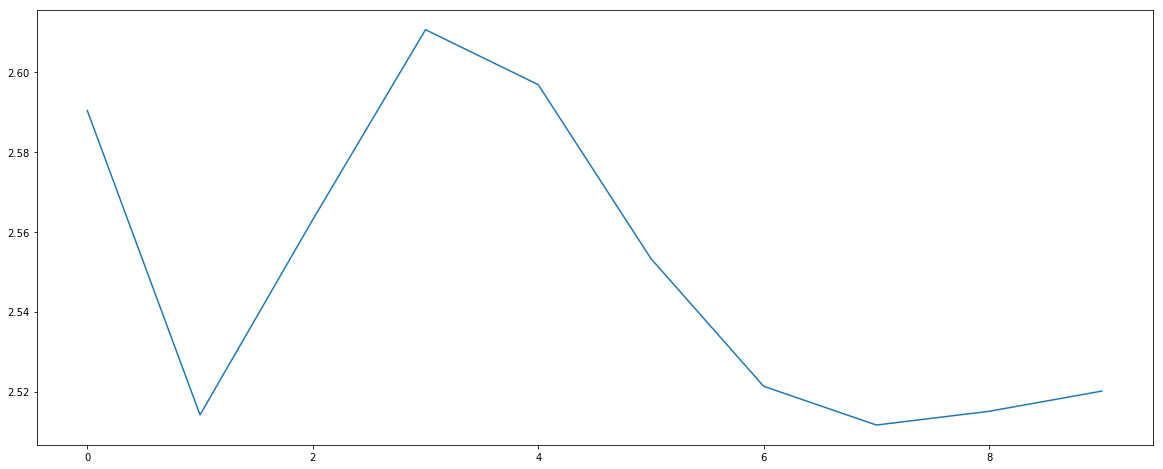

In [167]:
plt.plot(val_accuracy)

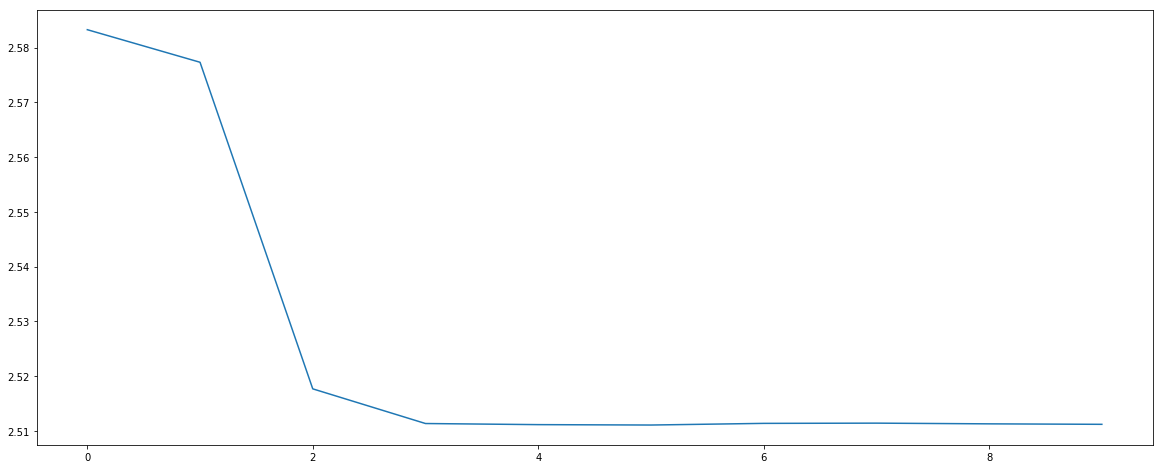

In [125]:
plt.plot(val_accuracy)

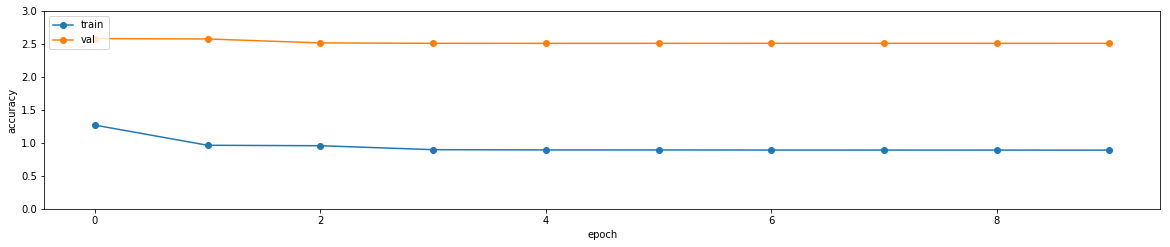

In [127]:

plt.subplot(2, 1, 2)
plt.plot(train_errors, '-o')
plt.plot(val_accuracy, '-o')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# plot prediction

In [104]:
np_prediction = prediction.cpu().numpy()

In [105]:
original_prediction = np_prediction*size_std

In [106]:
val_set = merged_days[:100]

In [107]:
val_set['original_size_prediction'] = original_prediction
val_set['prediction'] = np_prediction

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
validation_result = val_set[['well_id_1','original_hyst2_area_13','original_size_prediction']]

In [93]:
#validation_result.to_csv(figure_path+'size_prediction_for_validation.csv')

In [109]:
#validation_result = validation_result.sort_values(by='original_hyst2_area_13').set_index('original_hyst2_area_13').reset_index()

In [122]:
pred_truth_correlation = validation_result['original_hyst2_area_13'].corr(validation_result['original_size_prediction'])

In [123]:
pred_truth_correlation

-0.06908506599660129

<Figure size 1440x720 with 0 Axes>

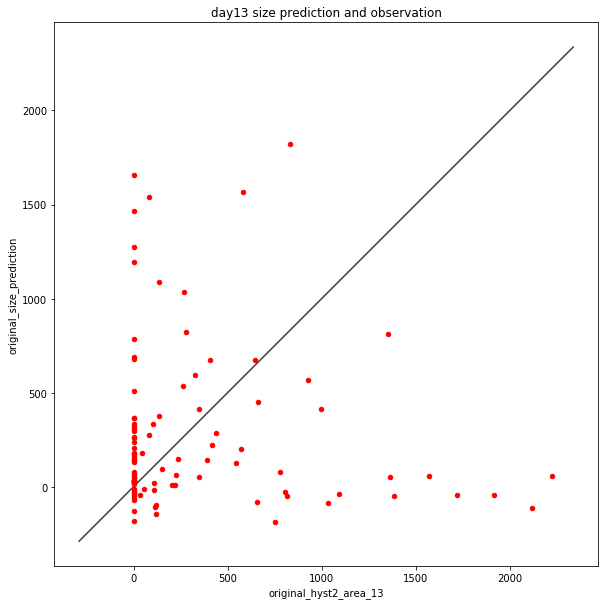

In [125]:
fig = plt.figure()
ax = validation_result.plot(kind='scatter', x='original_hyst2_area_13', y='original_size_prediction', color='r')  
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
plt.title("day13 size prediction and observation")
fig.savefig(figure_path+'size_prediction_and_observation_scatter_plot.pdf')

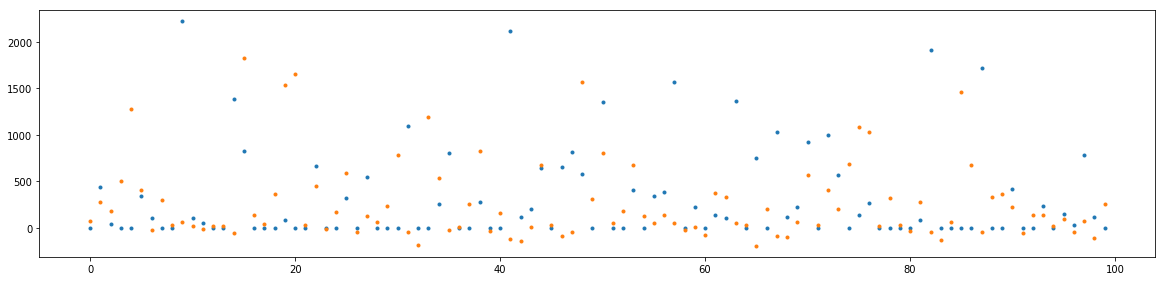

In [112]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(validation_result['original_hyst2_area_13'], '.')
plt.plot(validation_result['original_size_prediction'], '.')


In [ ]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(validation_result['original_hyst2_area_13'], '.-')
plt.plot(validation_result['original_size_prediction'], '.-')
plt.title("day13 size prediction and truth")
#plt.ylim(0,3)
plt.legend(['truth', 'prediction'], loc='upper right')
plt.xlabel('index')
plt.ylabel('day13 size')
plt.show()
#fig.savefig(figure_path+'size_prediction_and_truth.pdf')

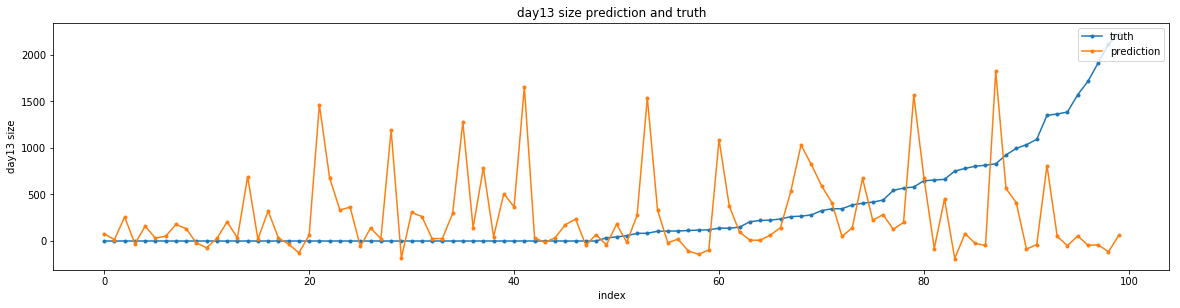

In [110]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(validation_result['original_hyst2_area_13'], '.-')
plt.plot(validation_result['original_size_prediction'], '.-')
plt.title("day13 size prediction and truth")
#plt.ylim(0,3)
plt.legend(['truth', 'prediction'], loc='upper right')
plt.xlabel('index')
plt.ylabel('day13 size')
plt.show()
fig.savefig(figure_path+'size_prediction_and_truth.pdf')

In [97]:
def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

def get_size_and_name(well_id,day_id,label):
    row = label[(label['well_id'] == well_id) & (label['day'] == day_id)]
    image_size = row['original_hyst2_area'].item()
    image_name = row['image_name'].item()
    return image_size, image_name    

def plot_image(well_id,day_id,label=label):
    image_size, image_name = get_size_and_name(well_id,day_id,label)
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=False)
    plt.title('day'+str(day_id)+' size='+str(image_size))

def random_plot(label=label):
    max_well_id = label['well_id'].max()+1
    
    random_well_id = np.random.randint(0,max_well_id)
    print("well id "+ str(random_well_id))
    plt.subplot(1, 4, 1)
    plot_image(random_well_id,0)
    plt.subplot(1, 4, 2)
    plot_image(random_well_id,1)
    plt.subplot(1, 4, 3)
    plot_image(random_well_id,8)
    plt.subplot(1, 4, 4)
    plot_image(random_well_id,13)

In [98]:
random_well_id = np.random.choice(val_set.well_id_1)

In [99]:
random_well_id

2666

In [100]:
random_well_prediction = val_set.query("well_id_13 == %d"%random_well_id)['original_size_prediction']

In [101]:
val_set.query("well_id_13 == %d"%random_well_id)

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,well_id_13,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst2_area_13,original_size_prediction,prediction
182,2666,1,121.0,9310,412,381,well2666_day01_well.png,2666,2666,13,130.0,8550,3101,2368,well2666_day13_well.png,1.862074,446.494843,0.351101


In [102]:
def random_plot_prediction():
    random_well_id = np.random.choice(val_set.well_id_1)
    random_well_prediction = val_set.query("well_id_13 == %d"%random_well_id)['original_size_prediction']
    fig = plt.figure()
    st = fig.suptitle("day13 size prediction : %d"%random_well_prediction, fontsize="x-large")    
    
    print("well id "+ str(random_well_id))
    plt.title('day13 size prediction')
    plt.subplot(1, 3, 1)
    plot_image(random_well_id,1)

    plt.subplot(1, 3, 2)
    plot_image(random_well_id,13)

    fig.savefig(figure_path+"well_%d_prediction.png"%random_well_id)


well id 3731


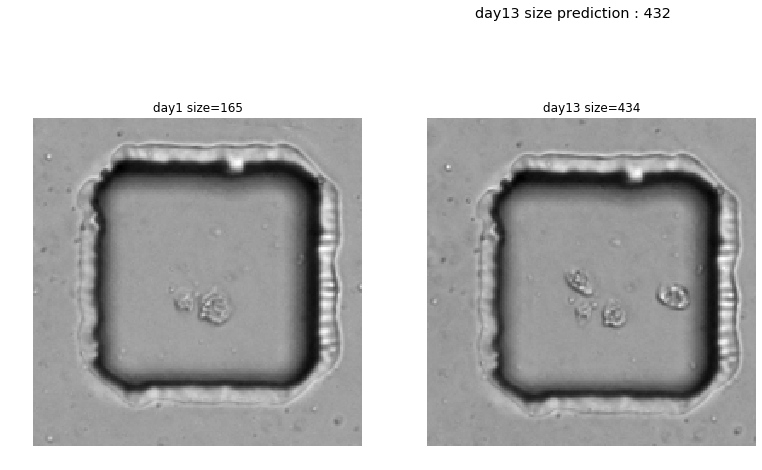

In [244]:
random_plot_prediction()

well id 2364


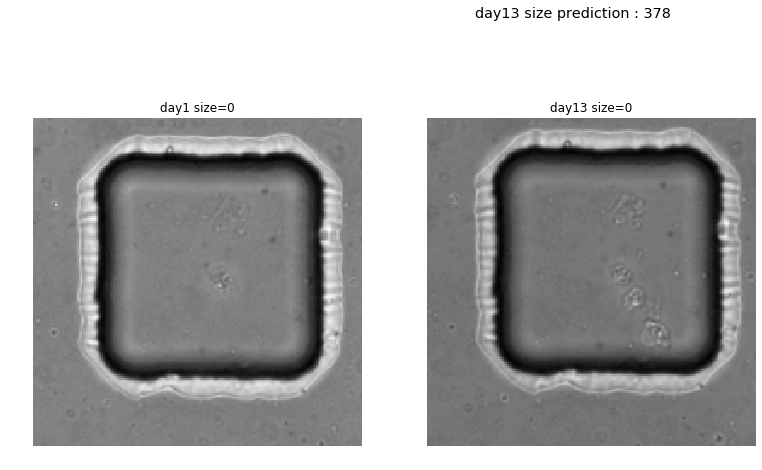

In [223]:
random_plot_prediction()

well id 3674


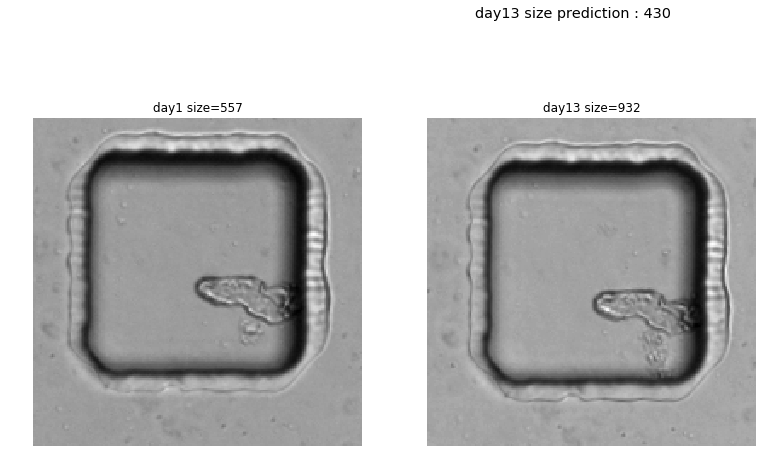

In [224]:
random_plot_prediction()

well id 1791


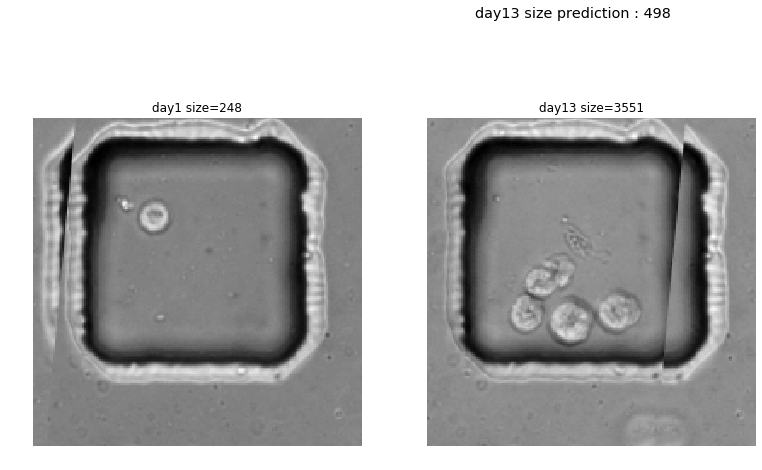

In [226]:
random_plot_prediction()

well id 2732


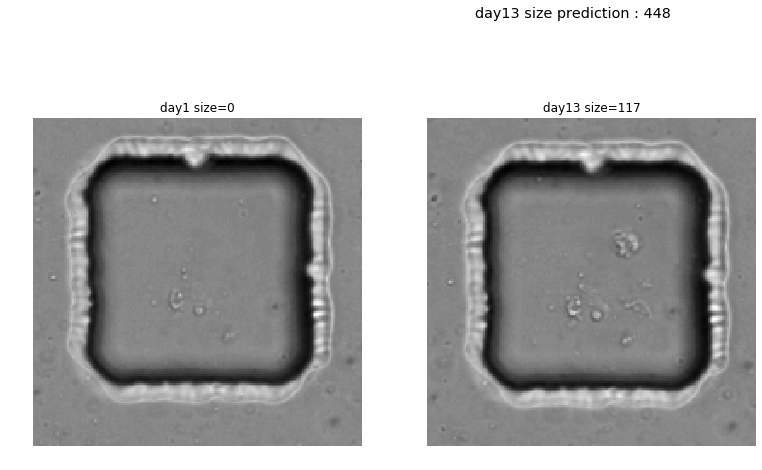

In [230]:
random_plot_prediction()

well id 4460


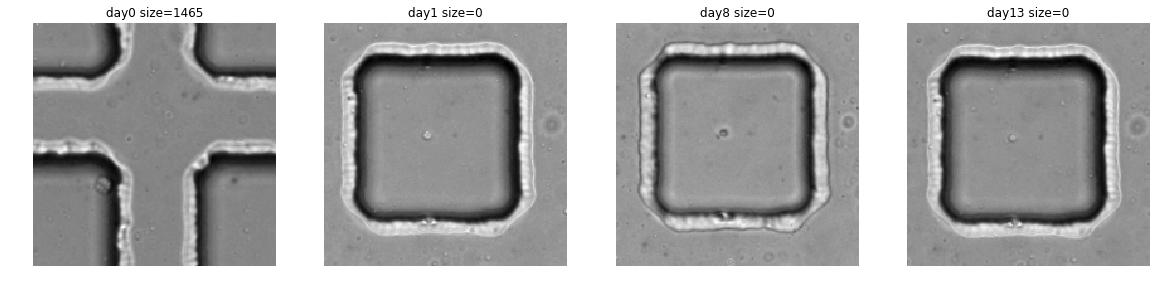

In [217]:
random_plot()